# 0. Базовые библиотеки и настройки

In [1]:
# !pip install termcolor
# !conda install -c conda-forge termcolor

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

## 0.1 Глобальные переменные и типы

In [3]:
from enum import Enum


class Verbosity(Enum):
    NONE = 1
    BASIC_TIME = 2
    ADVANCED_TIME_SCORE = 3
    EXTREME_TIME_SCORE_PARAMETERS = 3


ML_SEED = 42
ML_JOBS = 12


## 0.2 Логирование

In [4]:
import sys
import logging
from termcolor import colored


DEFAULT_LOGGER_NAME = "Hyper-Parameters"


def setup_applevel_logger(logger_name=DEFAULT_LOGGER_NAME, file_name=None):
    logger = logging.getLogger(logger_name)
    logger.setLevel(logging.DEBUG)

    formatter = logging.Formatter(
        "%(asctime)s - %(name)s - %(levelname)s - %(message)s")
    sh = logging.StreamHandler(sys.stdout)
    sh.setFormatter(formatter)

    logger.handlers.clear()
    logger.addHandler(sh)

    if file_name:
        fh = logging.FileHandler(file_name)
        fh.setFormatter(formatter)
        logger.addHandler(fh)

    return logger


# def get_logger(module_name):
#    return logging.getLogger(DEFAULT_LOGGER_NAME).getChild(module_name)


LOG = setup_applevel_logger(file_name=None)


# 1. Загрузка данных

In [5]:
data = pd.read_csv('_train_sem09.csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:xlabel='Activity', ylabel='count'>

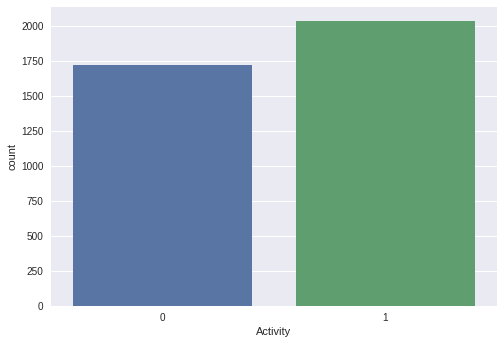

In [6]:
sns.countplot(data=data, x="Activity")

# 2. Базовые модели

In [36]:
from typing import Any
from typing import Type

from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


def make_holdout_sample_sklearn(X: pd.DataFrame, Y: pd.Series,
                                holdout_sample_size: float = 0.2, seed: int = None,
                                shuffle: bool = True, stratify: Any | None = None):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                        test_size=holdout_sample_size,
                                                        random_state=seed,
                                                        shuffle=shuffle, stratify=stratify)
    LOG.info(
        f"A holdout sample is selected. Train sample size - {len(Y_train)} ({1 - holdout_sample_size}), test sample size {len(Y_test)} ({holdout_sample_size}).")

    return {
        "X_train": X_train,
        "Y_train": Y_train,
        "X_test": X_test,
        "Y_test": Y_test
    }


def log_f1_scores(samples, optimization_algorithm_instance, log_precision_recall_accuracy=True):
    Y_predicted_train = optimization_algorithm_instance.predict(samples["X_train"])
    LOG.info(f"{colored('F1-score', 'red')}, train dataset: {metrics.f1_score(samples['Y_train'], Y_predicted_train)}")
    if log_precision_recall_accuracy:
        LOG.info(f"{colored('Precision', 'magenta')}, train dataset: {metrics.precision_score(samples['Y_train'], Y_predicted_train)}")
        LOG.info(f"{colored('Recall', 'blue')}, train dataset: {metrics.recall_score(samples['Y_train'], Y_predicted_train)}")
        LOG.info(f"{colored('Accuracy', 'green')}, train dataset: {metrics.accuracy_score(samples['Y_train'], Y_predicted_train)}")
    LOG.info("-----")
    Y_predicted_test = optimization_algorithm_instance.predict(samples["X_test"])
    LOG.info(f"{colored('F1-score', 'red')}, test dataset: {metrics.f1_score(samples['Y_test'], Y_predicted_test)}")
    if log_precision_recall_accuracy:
        LOG.info(f"{colored('Precision', 'magenta')}, test dataset: {metrics.precision_score(samples['Y_test'], Y_predicted_test)}")
        LOG.info(f"{colored('Recall', 'blue')}, test dataset: {metrics.recall_score(samples['Y_test'], Y_predicted_test)}")
        LOG.info(f"{colored('Accuracy', 'green')}, test dataset: {metrics.accuracy_score(samples['Y_test'], Y_predicted_test)}")

## 2.1 `LogisticRegression`

In [38]:
target_feature_name = 'Activity'
X = data.drop([target_feature_name], axis=1)
Y = data[target_feature_name]
samples = make_holdout_sample_sklearn(
    X, Y,
    holdout_sample_size=0.2,
    seed=ML_SEED,
    shuffle=True,
    stratify=Y
)

model = linear_model.LogisticRegression(
    C=0.1,
    penalty='l2',
    solver='sag',
    class_weight='balanced',
    max_iter=50,
    n_jobs=ML_JOBS,
    random_state=ML_SEED
)
model.fit(samples["X_train"], samples['Y_train'])


log_f1_scores(samples, model)

2022-07-14 21:27:02,423 - Hyper-Parameters - INFO - A holdout sample is selected. Train sample size - 3000 (0.8), test sample size 751 (0.2).
2022-07-14 21:27:04,018 - Hyper-Parameters - INFO - F1-score, train dataset: 0.850828729281768
2022-07-14 21:27:04,019 - Hyper-Parameters - INFO - Precision, train dataset: 0.8497854077253219
2022-07-14 21:27:04,020 - Hyper-Parameters - INFO - Recall, train dataset: 0.8518746158574063
2022-07-14 21:27:04,020 - Hyper-Parameters - INFO - Accuracy, train dataset: 0.838
2022-07-14 21:27:04,021 - Hyper-Parameters - INFO - -----
2022-07-14 21:27:04,031 - Hyper-Parameters - INFO - F1-score, test dataset: 0.7853658536585365
2022-07-14 21:27:04,032 - Hyper-Parameters - INFO - Precision, test dataset: 0.7796610169491526
2022-07-14 21:27:04,034 - Hyper-Parameters - INFO - Recall, test dataset: 0.7911547911547911
2022-07-14 21:27:04,034 - Hyper-Parameters - INFO - Accuracy, test dataset: 0.7656458055925432


## 2.2 `RandomForestClassifier`

In [43]:
model = ensemble.RandomForestClassifier(
    n_estimators=200,
    criterion='entropy',
    max_depth=6,
    min_samples_leaf=4,
    max_features=0.5,
    bootstrap=True,
    class_weight='balanced',
    n_jobs=ML_JOBS,
    random_state=ML_SEED
)
model.fit(samples["X_train"], samples['Y_train'])

log_f1_scores(samples, model)

2022-07-14 21:30:53,615 - Hyper-Parameters - INFO - F1-score, train dataset: 0.8470732454796199
2022-07-14 21:30:53,617 - Hyper-Parameters - INFO - Precision, train dataset: 0.8447432762836186
2022-07-14 21:30:53,618 - Hyper-Parameters - INFO - Recall, train dataset: 0.8494161032575291
2022-07-14 21:30:53,619 - Hyper-Parameters - INFO - Accuracy, train dataset: 0.8336666666666667
2022-07-14 21:30:53,619 - Hyper-Parameters - INFO - -----
2022-07-14 21:30:53,662 - Hyper-Parameters - INFO - F1-score, test dataset: 0.7852028639618138
2022-07-14 21:30:53,664 - Hyper-Parameters - INFO - Precision, test dataset: 0.7633410672853829
2022-07-14 21:30:53,665 - Hyper-Parameters - INFO - Recall, test dataset: 0.8083538083538083
2022-07-14 21:30:53,665 - Hyper-Parameters - INFO - Accuracy, test dataset: 0.7603195739014648


# 3. Базовая оптимизация моделей

In [8]:
from typing import Any
from typing import Type
from sklearn.model_selection._search import BaseSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
from sklearn import exceptions


warnings.simplefilter("ignore", category=exceptions.ConvergenceWarning)
warnings.filterwarnings("ignore", category=exceptions.ConvergenceWarning)


def make_holdout_sample_sklearn(X: pd.DataFrame, Y: pd.Series,
                                holdout_sample_size: float = 0.2, seed: int = None,
                                shuffle: bool = True, stratify: Any | None = None):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                        test_size=holdout_sample_size,
                                                        random_state=seed,
                                                        shuffle=shuffle, stratify=stratify)
    LOG.info(
        f"A holdout sample is selected. Train sample size - {len(Y_train)} ({1 - holdout_sample_size}), test sample size {len(Y_test)} ({holdout_sample_size}).")

    return {
        "X_train": X_train,
        "Y_train": Y_train,
        "X_test": X_test,
        "Y_test": Y_test
    }


def optimize_model_sklearn(data: pd.DataFrame, target_feature_name: str,
                           base_model_instance,
                           Type_optimization_algorithm: Type[BaseSearchCV], scoring_type: str,
                           hyper_parameters, cross_validation_parameter,
                           holdout_sample_size: float = 0.2, holdout_shuffle: bool = True,
                           max_iterations: int = 50,
                           verbosity: Verbosity = Verbosity.BASIC_TIME,
                           seed: int = None,
                           n_jobs: int = -1):
    assert Type_optimization_algorithm in [
        GridSearchCV, RandomizedSearchCV], "Supported optimizator types: GridSearchCV, RandomizedSearchCV."

    LOG.info("Optimization begins...")

    X = data.drop([target_feature_name], axis=1)
    Y = data[target_feature_name]
    XY_samples = make_holdout_sample_sklearn(
        X, Y,
        holdout_sample_size=holdout_sample_size,
        seed=seed,
        shuffle=holdout_shuffle,
        stratify=Y
    )

    optimization_algorithm_instance: BaseSearchCV = None

    if GridSearchCV == Type_optimization_algorithm:
        optimization_algorithm_instance = GridSearchCV(
            estimator=base_model_instance,
            param_grid=hyper_parameters,
            scoring=scoring_type,
            n_jobs=n_jobs,
            cv=cross_validation_parameter,
            verbose=verbosity.value
        )
    elif RandomizedSearchCV == Type_optimization_algorithm:
        optimization_algorithm_instance = RandomizedSearchCV(
            estimator=base_model_instance,
            param_distributions=hyper_parameters,
            n_iter=max_iterations,
            scoring=scoring_type,
            n_jobs=n_jobs,
            cv=cross_validation_parameter,
            verbose=verbosity.value
        )
    else:
        raise AssertionError(
            "Supported optimizator types: GridSearchCV, RandomizedSearchCV.")

    LOG.info(f"Selected optimizator algorithm - {type(optimization_algorithm_instance)}.")

    X_train = XY_samples["X_train"]
    Y_train = XY_samples["Y_train"]
    LOG.info("Hyperparameters fitting...")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=exceptions.ConvergenceWarning)
        warnings.filterwarnings("ignore", category=exceptions.ConvergenceWarning)
        %time optimization_algorithm_instance.fit(X_train, Y_train)
    LOG.info("Hyperparameters fitting... done.")

    X_test = XY_samples["X_test"]
    Y_test = XY_samples["Y_test"]
    score_value = optimization_algorithm_instance.score(X_test, Y_test)
    LOG.info(f"Best '{scoring_type}' value - {score_value}")
    LOG.info(f"Best hyper-parameters found:\n{optimization_algorithm_instance.best_params_}")

    return optimization_algorithm_instance, XY_samples


def log_f1_scores(samples, optimization_algorithm_instance, log_precision_recall_accuracy=True):
    Y_predicted_train = optimization_algorithm_instance.predict(samples["X_train"])
    LOG.info(f"{colored('F1-score', 'red')}, train dataset: {metrics.f1_score(samples['Y_train'], Y_predicted_train)}")
    if log_precision_recall_accuracy:
        LOG.info(f"{colored('Precision', 'magenta')}, train dataset: {metrics.precision_score(samples['Y_train'], Y_predicted_train)}")
        LOG.info(f"{colored('Recall', 'blue')}, train dataset: {metrics.recall_score(samples['Y_train'], Y_predicted_train)}")
        LOG.info(f"{colored('Accuracy', 'green')}, train dataset: {metrics.accuracy_score(samples['Y_train'], Y_predicted_train)}")
    LOG.info("-----")
    Y_predicted_test = optimization_algorithm_instance.predict(samples["X_test"])
    LOG.info(f"{colored('F1-score', 'red')}, test dataset: {metrics.f1_score(samples['Y_test'], Y_predicted_test)}")
    if log_precision_recall_accuracy:
        LOG.info(f"{colored('Precision', 'magenta')}, test dataset: {metrics.precision_score(samples['Y_test'], Y_predicted_test)}")
        LOG.info(f"{colored('Recall', 'blue')}, test dataset: {metrics.recall_score(samples['Y_test'], Y_predicted_test)}")
        LOG.info(f"{colored('Accuracy', 'green')}, test dataset: {metrics.accuracy_score(samples['Y_test'], Y_predicted_test)}")


## 3.1 `GridSearchCV` + `LogisticRegression`

In [10]:
hyper_parameters = [
    # {
    #     'penalty': ['l2'], # 'none' не сходится ни при каком числе итераций
    #     'solver': ['lbfgs'],
    #     'C': np.arange(0.014, 0.02+0.001, 0.001),
    #     'class_weight': ['balanced', None],
    #     'max_iter': np.arange(400, 900+100, 100),
    #     'n_jobs' : [ML_JOBS]
    # },
    # {
    #     'penalty': ['l2'], # 'none' не сходится ни при каком числе итераций
    #     'solver': ['sag'],
    #     'C': np.arange(0.016, 0.024+0.001, 0.001),
    #     'class_weight': ['balanced', None],
    #     'max_iter': np.arange(400, 900+100, 100),
    #     'n_jobs' : [ML_JOBS]
    # },
    # {
    #     'penalty': ['l1'],  # С 'none' не сходится ни при каком числе итераций.
    #     'solver': ['saga'],
    #     'C': np.arange(0.001, 0.01+0.001, 0.001),
    #     'class_weight': ['balanced', None],
    #     'max_iter': np.arange(400, 900+100, 100),
    #     'n_jobs' : [ML_JOBS]
    # },
    # {
    #     'penalty': ['l2'],
    #     'solver': ['saga'],
    #     'C': np.arange(0.015, 0.03+0.001, 0.001),
    #     'class_weight': ['balanced', None],
    #     'max_iter': np.arange(400, 900+100, 100),
    #     'n_jobs' : [ML_JOBS]
    # },
    # {
    #     'penalty': ['elasticnet'],
    #     'solver': ['saga'],
    #     'C': np.arange(0.018, 0.027+0.001, 0.001),
    #     'class_weight': ['balanced', None],
    #     'max_iter': np.arange(400, 900+100, 100),
    #     'l1_ratio': np.arange(0.006, 0.012+0.001, 0.001),
    #     'n_jobs' : [ML_JOBS]
    # },
    {
        'penalty': ['l1', 'l2'], # С 'elasticnet' не сходится в принципе.
        'solver': ['liblinear'],
        'C': np.arange(0.05, 0.1+0.005, 0.005),
        'class_weight': ['balanced', None],
        'max_iter': np.arange(40, 60+2, 2),
        'n_jobs' : [1]
    },
    # {
    #     'penalty': ['l2'], # 'none' при увеличении числа итераций не даёт сходимости.
    #     'solver': ['newton-cg'],
    #     'C': np.arange(0.05, 0.1+0.005, 0.005),
    #     'class_weight': ['balanced', None],
    #     'max_iter': np.arange(40, 60+2, 2),
    #     'n_jobs' : [ML_JOBS]
    # }
]

base_model = linear_model.LogisticRegression(random_state=ML_SEED, n_jobs=ML_JOBS)
optimization_algorithm_instance, samples = optimize_model_sklearn(data, "Activity",
                                                                  base_model,
                                                                  GridSearchCV, scoring_type='f1',
                                                                  hyper_parameters=hyper_parameters, cross_validation_parameter=5,
                                                                  holdout_sample_size=0.2, holdout_shuffle=True,
                                                                  verbosity=Verbosity.NONE,
                                                                  seed=ML_SEED,
                                                                  n_jobs=ML_JOBS)


log_f1_scores(samples, optimization_algorithm_instance)

2022-07-14 18:39:11,307 - Hyper-Parameters - INFO - Optimization begins...
2022-07-14 18:39:11,380 - Hyper-Parameters - INFO - A holdout sample is selected. Train sample size - 3000 (0.8), test sample size 751 (0.2).
2022-07-14 18:39:11,381 - Hyper-Parameters - INFO - Selected optimizator algorithm - <class 'sklearn.model_selection._search.GridSearchCV'>.
2022-07-14 18:39:11,382 - Hyper-Parameters - INFO - Hyperparameters fitting...
Fitting 5 folds for each of 528 candidates, totalling 2640 fits
CPU times: user 15.9 s, sys: 1.66 s, total: 17.5 s
Wall time: 3min 36s
2022-07-14 18:42:48,299 - Hyper-Parameters - INFO - Hyperparameters fitting... done.
2022-07-14 18:42:48,350 - Hyper-Parameters - INFO - Best 'f1' value - 0.7834319526627218
2022-07-14 18:42:48,351 - Hyper-Parameters - INFO - Best hyper-parameters found:
{'C': 0.055, 'class_weight': None, 'max_iter': 40, 'n_jobs': 1, 'penalty': 'l2', 'solver': 'liblinear'}
2022-07-14 18:42:48,432 - Hyper-Parameters - INFO - F1-score, train d

## 3.2 `RandomizedSearchCV` + `LogisticRegression`

In [11]:
hyper_parameters = [
    {
        'penalty': ['l2'], # 'none' не сходится ни при каком числе итераций
        'solver': ['lbfgs'],
        'C': np.arange(0.014, 0.02+0.001, 0.001),
        'class_weight': ['balanced', None],
        'max_iter': np.arange(400, 900+100, 100),
        'n_jobs' : [ML_JOBS]
    },
    {
        'penalty': ['l2'], # 'none' не сходится ни при каком числе итераций
        'solver': ['sag'],
        'C': np.arange(0.016, 0.024+0.001, 0.001),
        'class_weight': ['balanced', None],
        'max_iter': np.arange(400, 900+100, 100),
        'n_jobs' : [ML_JOBS]
    },
    {
        'penalty': ['l1'],  # С 'none' не сходится ни при каком числе итераций.
        'solver': ['saga'],
        'C': np.arange(0.001, 0.01+0.001, 0.001),
        'class_weight': ['balanced', None],
        'max_iter': np.arange(400, 900+100, 100),
        'n_jobs' : [ML_JOBS]
    },
    {
        'penalty': ['l2'],
        'solver': ['saga'],
        'C': np.arange(0.015, 0.03+0.001, 0.001),
        'class_weight': ['balanced', None],
        'max_iter': np.arange(400, 900+100, 100),
        'n_jobs' : [ML_JOBS]
    },
    {
        'penalty': ['elasticnet'],
        'solver': ['saga'],
        'C': np.arange(0.018, 0.027+0.001, 0.001),
        'class_weight': ['balanced', None],
        'max_iter': np.arange(400, 900+100, 100),
        'l1_ratio': np.arange(0.006, 0.012+0.001, 0.001),
        'n_jobs' : [ML_JOBS]
    },
    {
        'penalty': ['l1', 'l2'], # С 'elasticnet' не сходится в принципе.
        'solver': ['liblinear'],
        'C': np.arange(0.05, 0.1+0.005, 0.005),
        'class_weight': ['balanced', None],
        'max_iter': np.arange(40, 60+2, 2),
        'n_jobs' : [1]
    },
    {
        'penalty': ['l2'], # 'none' при увеличении числа итераций не даёт сходимости.
        'solver': ['newton-cg'],
        'C': np.arange(0.05, 0.1+0.005, 0.005),
        'class_weight': ['balanced', None],
        'max_iter': np.arange(40, 60+2, 2),
        'n_jobs' : [ML_JOBS]
    }
]

base_model = linear_model.LogisticRegression(random_state=ML_SEED)
optimization_algorithm_instance, samples = optimize_model_sklearn(data, "Activity",
                                                                  base_model,
                                                                  RandomizedSearchCV, scoring_type='f1',
                                                                  hyper_parameters=hyper_parameters, cross_validation_parameter=5,
                                                                  holdout_sample_size=0.2, holdout_shuffle=True,
                                                                  max_iterations=100,
                                                                  verbosity=Verbosity.NONE,
                                                                  seed=ML_SEED,
                                                                  n_jobs=ML_JOBS)

log_f1_scores(samples, optimization_algorithm_instance)


2022-07-14 18:43:21,829 - Hyper-Parameters - INFO - Optimization begins...
2022-07-14 18:43:21,924 - Hyper-Parameters - INFO - A holdout sample is selected. Train sample size - 3000 (0.8), test sample size 751 (0.2).
2022-07-14 18:43:21,924 - Hyper-Parameters - INFO - Selected optimizator algorithm - <class 'sklearn.model_selection._search.RandomizedSearchCV'>.
2022-07-14 18:43:21,925 - Hyper-Parameters - INFO - Hyperparameters fitting...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 11.4 s, sys: 159 ms, total: 11.6 s
Wall time: 5min 43s
2022-07-14 18:49:05,368 - Hyper-Parameters - INFO - Hyperparameters fitting... done.
2022-07-14 18:49:05,394 - Hyper-Parameters - INFO - Best 'f1' value - 0.7796208530805686
2022-07-14 18:49:05,396 - Hyper-Parameters - INFO - Best hyper-parameters found:
{'solver': 'saga', 'penalty': 'elasticnet', 'n_jobs': 12, 'max_iter': 400, 'l1_ratio': 0.011, 'class_weight': None, 'C': 0.021}
2022-07-14 18:49:05,427 - Hyper-Paramete

## 3.3 `RandomizedSearchCV` + `RandomForestClassifier`

In [12]:
hyper_parameters = [
    {
        'n_estimators': [250, 300, 350], # Увеличение числа деревьев не сильно даёт улучшение здесь: 200, 300 или 500 - разница невелика.
        'criterion': ["entropy", "log_loss"], # Эти параметры могут выигрывать попеременно, вероятно в зависимости от max_features.
        'max_depth': [7, 8], # Какой диапазон, ни ставь, в целом выбираются более переобученные модели с большей глубиной.
        'min_samples_leaf': [3, 4], # Аналогично, но в сторону уменьшения числа примеров в листе.
        'max_features' : np.arange(0.33, 0.39, 0.005), # Примерно в интервале от 0.29 до 0.4 могут получаться приличные пары значений f1-score на выборках train и test.
        'bootstrap': [True], # Всегда выигрывало значение True.
        'class_weight' : ["balanced", None], # Всегда выигрывало значение "balanced".
        'n_jobs' : [ML_JOBS] # Иногда помогает уменьшать затраченное машинное время при одновременном параллельном вычислении в RandomizedSearchCV.
    }
]

base_model = ensemble.RandomForestClassifier(random_state=ML_SEED)
optimization_algorithm_instance, samples = optimize_model_sklearn(data, "Activity",
                                                                  base_model,
                                                                  RandomizedSearchCV, scoring_type='f1',
                                                                  hyper_parameters=hyper_parameters, cross_validation_parameter=5,
                                                                  holdout_sample_size=0.2, holdout_shuffle=True,
                                                                  max_iterations=10,
                                                                  verbosity=Verbosity.NONE,
                                                                  seed=ML_SEED,
                                                                  n_jobs=ML_JOBS + 2)


log_f1_scores(samples, optimization_algorithm_instance)

2022-07-14 18:49:38,988 - Hyper-Parameters - INFO - Optimization begins...
2022-07-14 18:49:39,071 - Hyper-Parameters - INFO - A holdout sample is selected. Train sample size - 3000 (0.8), test sample size 751 (0.2).
2022-07-14 18:49:39,072 - Hyper-Parameters - INFO - Selected optimizator algorithm - <class 'sklearn.model_selection._search.RandomizedSearchCV'>.
2022-07-14 18:49:39,073 - Hyper-Parameters - INFO - Hyperparameters fitting...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 45 s, sys: 108 ms, total: 45.1 s
Wall time: 2min 37s
2022-07-14 18:52:16,269 - Hyper-Parameters - INFO - Hyperparameters fitting... done.
2022-07-14 18:52:16,339 - Hyper-Parameters - INFO - Best 'f1' value - 0.795266272189349
2022-07-14 18:52:16,340 - Hyper-Parameters - INFO - Best hyper-parameters found:
{'n_jobs': 12, 'n_estimators': 350, 'min_samples_leaf': 4, 'max_features': 0.34500000000000003, 'max_depth': 8, 'criterion': 'log_loss', 'class_weight': None, 'bootstrap': T

## 3.4 `GridSearchCV` + `RandomForestClassifier`

Приходится ограничивать наборы параметров, чтобы их полный перебор не занимал сутки и более.

In [14]:
hyper_parameters = [
    {
        'n_estimators': [250, 300, 350], # Увеличение числа деревьев не сильно даёт улучшение здесь: 200, 300 или 500 - разница невелика.
        'criterion': ["entropy", "log_loss"], # Эти параметры могут выигрывать попеременно, вероятно в зависимости от max_features.
        'max_depth': [7, 8], # Какой диапазон, ни ставь, в целом выбираются более переобученные модели с большей глубиной.
        'min_samples_leaf': [3, 4], # Аналогично, но в сторону уменьшения числа примеров в листе.
        'max_features' : [0.35, 0.4],
        'bootstrap': [True], # Всегда выигрывало значение True.
        'class_weight' : ["balanced", None], # Всегда выигрывало значение "balanced".
        'n_jobs' : [ML_JOBS] # Иногда помогает уменьшать затраченное машинное время при одновременном параллельном вычислении в RandomizedSearchCV.
    }
]

base_model = ensemble.RandomForestClassifier(random_state=ML_SEED)
optimization_algorithm_instance, samples = optimize_model_sklearn(data, "Activity",
                                                                  base_model,
                                                                  GridSearchCV, scoring_type='f1',
                                                                  hyper_parameters=hyper_parameters, cross_validation_parameter=5,
                                                                  holdout_sample_size=0.2, holdout_shuffle=True,
                                                                  verbosity=Verbosity.NONE,
                                                                  seed=ML_SEED,
                                                                  n_jobs=14)

log_f1_scores(samples, optimization_algorithm_instance)

2022-07-14 19:47:01,709 - Hyper-Parameters - INFO - Optimization begins...
2022-07-14 19:47:01,776 - Hyper-Parameters - INFO - A holdout sample is selected. Train sample size - 3000 (0.8), test sample size 751 (0.2).
2022-07-14 19:47:01,777 - Hyper-Parameters - INFO - Selected optimizator algorithm - <class 'sklearn.model_selection._search.GridSearchCV'>.
2022-07-14 19:47:01,777 - Hyper-Parameters - INFO - Hyperparameters fitting...
Fitting 5 folds for each of 96 candidates, totalling 480 fits
CPU times: user 31.2 s, sys: 314 ms, total: 31.5 s
Wall time: 23min 53s
2022-07-14 20:10:55,783 - Hyper-Parameters - INFO - Hyperparameters fitting... done.
2022-07-14 20:10:55,839 - Hyper-Parameters - INFO - Best 'f1' value - 0.7947805456702255
2022-07-14 20:10:55,840 - Hyper-Parameters - INFO - Best hyper-parameters found:
{'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 0.35, 'min_samples_leaf': 4, 'n_estimators': 250, 'n_jobs': 12}
2022-07-14 2

Метрика recall довольно высока даже на тестовой выборке, а вот precision заметно падает. Возможно при достаточном количестве машинного времени удатся найти баланс между метриками, чтобы приходилось меньше тестировать препараты в реальных тестах.

# 4. Продвинутая оптимизация

## 4.1 `hyperopt`

### 4.1.1 `hyperopt` + `LogisticRegressionCV`

In [19]:
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials


LOG.info(f"Hyperopt Version: {hyperopt.__version__}")


def objective(parameters, X=samples["X_train"], y=samples["Y_train"], cv=5, random_state=ML_SEED):
    # LOG.info(f"Case type: \"{colored(parameters['case-type'], 'green')}\"; Parameters: {parameters}.")

    model = linear_model.LogisticRegression(
        C=parameters['C'],
        penalty=parameters['penalty'],
        solver=parameters['solver'],
        class_weight=parameters['class_weight'],
        max_iter=parameters['max_iter'],
        l1_ratio=parameters['l1_ratio'] if 'l1_ratio' in parameters else None,
        n_jobs=parameters['n_jobs'],
        random_state=random_state
    )

    with warnings.catch_warnings():
        warnings.filterwarnings("error")
        try:
            score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
            # LOG.info(f"Case \"{colored(parameters['case-type'], 'green')}\"; Score: {colored(score, 'red')}\n----------")
            return -score
        except Warning or exceptions.NotFittedError:
            LOG.info(f"Case \"{colored(parameters['case-type'], 'red')}\"; NOT FITTED; Parameters: {parameters}.\n----------")
            return 10000.0

2022-07-14 20:25:32,417 - Hyper-Parameters - INFO - Hyperopt Version: 0.2.7


In [22]:
ML_JOBS = 12 # К сожалению только при числе "потоков" 1 удаётся скрыть ненужные ConvergenceWarning в scikit-learn...
hyper_parameters = hp.choice('cases', [
    {
        'case-type': 'lbfgs+l2',
        'solver': 'lbfgs',
        'penalty': 'l2',
        'C': hp.quniform('lbfgs+l2-C', 0.014, 0.02, 0.001),
        'class_weight': hp.choice('lbfgs+l2-class_weight', ['balanced', None]),
        'max_iter': hp.choice('lbfgs+l2-max_iter', np.arange(400, 900, 100, dtype=int)),
        'n_jobs': ML_JOBS
    },
    {
        'case-type': 'sag+l2',
        'solver': 'sag',
        'penalty': 'l2',
        'C': hp.quniform('sag+l2-C', 0.016, 0.024, 0.001),
        'class_weight': hp.choice('sag+l2-class_weight', ['balanced', None]),
        'max_iter': hp.choice('sag+l2-max_iter', np.arange(400, 900, 100, dtype=int)),
        'n_jobs': ML_JOBS
    },
    {
        'case-type': 'saga+l1',
        'penalty': 'l1',
        'solver': 'saga',
        'C': hp.quniform('saga+l1-C', 0.001, 0.01, 0.001),
        'class_weight': hp.choice('saga+l1-class_weight', ['balanced', None]),
        'max_iter': hp.choice('sag+l1-max_iter', np.arange(400, 900, 100, dtype=int)),
        'n_jobs': ML_JOBS
    },
    {
        'case-type': 'saga+l2',
        'penalty': 'l2',
        'solver': 'saga',
        'C': hp.quniform('saga+l2-C', 0.015, 0.03, 0.001),
        'class_weight': hp.choice('saga+l2-class_weight', ['balanced', None]),
        'max_iter': hp.choice('saga+l2-max_iter', np.arange(400, 900, 100, dtype=int)),
        'n_jobs' : ML_JOBS
    },
    {
        'case-type': 'saga+elasticnet',
        'penalty': 'elasticnet',
        'solver': 'saga',
        'C': hp.quniform('saga+elasticnet-C', 0.018, 0.027, 0.001),
        'class_weight': hp.choice('saga+elasticnet-class_weight', ['balanced', None]),
        'max_iter': hp.choice('saga+elasticnet-max_iter', np.arange(400, 900, 100, dtype=int)),
        'l1_ratio': hp.quniform('saga+elasticnet-l1_ratio', 0.006, 0.012, 0.001),
        'n_jobs': ML_JOBS
    },
    {
        'case-type': 'liblinear+l1_l2',
        'penalty': hp.choice('liblinear+l1_l2-penalty', ['l1', 'l2']),
        'solver': 'liblinear',
        'C': hp.quniform('liblinear+l1_l2-C', 0.05, 0.1, 0.005),
        'class_weight': hp.choice('liblinear+l1_l2-class_weight', ['balanced', None]),
        'max_iter': hp.choice('liblinear+l1_l2-max_iter', np.arange(40, 60, 2, dtype=int)),
        'n_jobs' : 1
    },
    {
        'case-type': 'newton-cg+l2',
        'penalty': 'l2',
        'solver': 'newton-cg',
        'C': hp.quniform('newton-cg+l2-C', 0.05, 0.1, 0.005),
        'class_weight': hp.choice('newton-cg+l2-class_weight', ['balanced', None]),
        'max_iter': hp.choice('newton-cg+l2-max_iter', np.arange(40, 60, 2, dtype=int)),
        'n_jobs' : ML_JOBS
    }
])


target_feature_name = "Activity" 
X = data.drop([target_feature_name], axis=1)
Y = data[target_feature_name]
samples = make_holdout_sample_sklearn(
    X, Y,
    holdout_sample_size=0.2,
    seed=ML_SEED,
    shuffle=True,
    stratify=Y
)


LOG.info(f"Starting Hyperopt minimization.")
trials = Trials()
best = fmin(
    objective,
    space=hyper_parameters,
    algo=tpe.suggest,
    max_evals=40,
    trials=trials,
    rstate=np.random.default_rng(ML_SEED),
    show_progressbar=True,
    verbose=True
)


best_parameters = hyperopt.space_eval(hyper_parameters, best)
LOG.info(f"Best hyper-parameters: {hyperopt.space_eval(hyper_parameters, best)}")

best_model = linear_model.LogisticRegression(
    C=best_parameters['C'],
    penalty=best_parameters['penalty'],
    solver=best_parameters['solver'],
    class_weight=best_parameters['class_weight'],
    max_iter=best_parameters['max_iter'],
    l1_ratio=best_parameters['l1_ratio'] if 'l1_ratio' in best_parameters else None,
    n_jobs=best_parameters['n_jobs'],
    random_state=ML_SEED,
)
best_model.fit(samples['X_train'], samples['Y_train'])

log_f1_scores(samples, best_model)

2022-07-14 20:28:09,214 - Hyper-Parameters - INFO - A holdout sample is selected. Train sample size - 3000 (0.8), test sample size 751 (0.2).
2022-07-14 20:28:09,215 - Hyper-Parameters - INFO - Starting Hyperopt minimization.
100%|██████████| 40/40 [02:10<00:00,  3.25s/trial, best loss: -0.794791603133382]
2022-07-14 20:30:19,316 - Hyper-Parameters - INFO - Best hyper-parameters: {'C': 0.019, 'case-type': 'lbfgs+l2', 'class_weight': None, 'max_iter': 800, 'n_jobs': 12, 'penalty': 'l2', 'solver': 'lbfgs'}
2022-07-14 20:30:23,820 - Hyper-Parameters - INFO - F1-score, train dataset: 0.8305389221556886
2022-07-14 20:30:23,822 - Hyper-Parameters - INFO - Precision, train dataset: 0.8096906012842966
2022-07-14 20:30:23,823 - Hyper-Parameters - INFO - Recall, train dataset: 0.8524892440073756
2022-07-14 20:30:23,823 - Hyper-Parameters - INFO - Accuracy, train dataset: 0.8113333333333334
2022-07-14 20:30:23,824 - Hyper-Parameters - INFO - -----
2022-07-14 20:30:23,833 - Hyper-Parameters - INFO

### 4.1.2 `hyperopt` + `RandomForestClassifier`

In [23]:
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials


def objective(parameters, X=samples["X_train"], y=samples["Y_train"], cv=5, random_state=ML_SEED):
    # LOG.info(f"Parameters: {parameters}.")

    model = ensemble.RandomForestClassifier(
        n_estimators=parameters['n_estimators'],
        criterion=parameters['criterion'],
        max_depth=parameters['max_depth'],
        min_samples_leaf=parameters['min_samples_leaf'],
        max_features=parameters['max_features'],
        bootstrap=parameters['bootstrap'],
        class_weight=parameters['class_weight'],
        n_jobs=parameters['n_jobs'],
        random_state=random_state
    )

    with warnings.catch_warnings():
        warnings.filterwarnings("error")
        try:
            # model.fit(X, y)
            score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
            return -score
        except Warning or exceptions.NotFittedError:
            LOG.info(f"NOT FITTED; Parameters: {parameters}.\n----------")
            return 10000.0

In [24]:
ML_JOBS = 12
hyper_parameters = {
    'n_estimators': hp.choice('n_estimators', [250, 300, 350]), # Увеличение числа деревьев не сильно даёт улучшение здесь: 200, 300 или 500 - разница невелика.
    'criterion': hp.choice('criterion', ["entropy", "log_loss"]), # Эти параметры могут выигрывать попеременно, вероятно в зависимости от max_features.
    'max_depth': hp.choice('max_depth', [7, 8]), # Какой диапазон, ни ставь, в целом выбираются более переобученные модели с большей глубиной.
    'min_samples_leaf': hp.choice('min_samples_leaf', [3, 4]), # Аналогично, но в сторону уменьшения числа примеров в листе.
    'max_features' : hp.quniform('max_features', 0.2, 0.5, 0.02),
    'bootstrap': True, # Всегда выигрывало значение True.
    'class_weight' : hp.choice('class_weight', ["balanced", None]), # Всегда выигрывало значение "balanced".
    'n_jobs' : ML_JOBS # Иногда помогает уменьшать затраченное машинное время при одновременном параллельном вычислении в RandomizedSearchCV.
}


target_feature_name = "Activity"
X = data.drop([target_feature_name], axis=1)
Y = data[target_feature_name]
samples = make_holdout_sample_sklearn(
    X, Y,
    holdout_sample_size=0.2,
    seed=ML_SEED,
    shuffle=True,
    stratify=Y
)


LOG.info(f"Starting Hyperopt minimization.")
trials = Trials()
best = fmin(
    objective,
    space=hyper_parameters,
    algo=tpe.suggest,
    max_evals=40,
    trials=trials,
    rstate=np.random.default_rng(ML_SEED),
    show_progressbar=True,
    verbose=True
)


best_parameters = hyperopt.space_eval(hyper_parameters, best)
LOG.info(f"Best hyper-parameters: {hyperopt.space_eval(hyper_parameters, best)}")

best_model = ensemble.RandomForestClassifier(
    n_estimators=best_parameters['n_estimators'],
    criterion=best_parameters['criterion'],
    max_depth=best_parameters['max_depth'],
    min_samples_leaf=best_parameters['min_samples_leaf'],
    bootstrap=best_parameters['bootstrap'],
    class_weight=best_parameters['class_weight'],
    n_jobs=best_parameters['n_jobs'],
    random_state=ML_SEED
)


best_model.fit(samples['X_train'], samples['Y_train'])

log_f1_scores(samples, best_model)

2022-07-14 20:32:36,617 - Hyper-Parameters - INFO - A holdout sample is selected. Train sample size - 3000 (0.8), test sample size 751 (0.2).
2022-07-14 20:32:36,617 - Hyper-Parameters - INFO - Starting Hyperopt minimization.
100%|██████████| 40/40 [09:59<00:00, 14.99s/trial, best loss: -0.8119676180118495]
2022-07-14 20:42:36,409 - Hyper-Parameters - INFO - Best hyper-parameters: {'bootstrap': True, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 8, 'max_features': 0.5, 'min_samples_leaf': 4, 'n_estimators': 300, 'n_jobs': 12}
2022-07-14 20:42:37,026 - Hyper-Parameters - INFO - F1-score, train dataset: 0.8812519177661859
2022-07-14 20:42:37,028 - Hyper-Parameters - INFO - Precision, train dataset: 0.8799019607843137
2022-07-14 20:42:37,029 - Hyper-Parameters - INFO - Recall, train dataset: 0.8826060233558697
2022-07-14 20:42:37,030 - Hyper-Parameters - INFO - Accuracy, train dataset: 0.871
2022-07-14 20:42:37,030 - Hyper-Parameters - INFO - -----
2022-07-14 20:42:37,094 - 

## 4.2 `optuna`

In [25]:
import optuna

LOG.info(f"Hyperopt Version: {hyperopt.__version__}")

2022-07-14 20:43:15,302 - Hyper-Parameters - INFO - Hyperopt Version: 0.2.7


### 4.2.1 `optuna` + `LogisticRegression`

In [26]:
target_feature_name = "Activity"
X = data.drop([target_feature_name], axis=1)
Y = data[target_feature_name]
samples = make_holdout_sample_sklearn(
    X, Y,
    holdout_sample_size=0.2,
    seed=ML_SEED,
    shuffle=True,
    stratify=Y
)


def objective(trial: optuna.Trial):

    # the method to use is a hyperparameter to optimize
    method = trial.suggest_categorical(
        "method", [
            'lbfgs+l2',
            'sag+l2',
            'saga+l1', 'saga+l2', 'saga+elasticnet',
            'liblinear+l1_l2',
            'newton-cg+l2'
        ]
    )

    solver       = trial.suggest_categorical('solver',       ['lbfgs', 'sag', 'saga', 'liblinear', 'newton-cg'])
    penalty      = trial.suggest_categorical('penalty',      ['l1', 'l2', 'elasticnet'])
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])
    n_jobs       = trial.suggest_categorical('n_jobs',       [ML_JOBS, 1])

    # LOG.info(f"TRIAL: solver {solver}, penalty {penalty}, class_weight {class_weight}")

    p_are_appropriate = False
    match method:
        case 'lbfgs+l2':        p_are_appropriate = all([solver == 'lbfgs',     penalty in ['l2'],         class_weight in ['balanced', None], n_jobs == ML_JOBS]),
        case 'sag+l2':          p_are_appropriate = all([solver == 'sag',       penalty in ['l2'],         class_weight in ['balanced', None], n_jobs == ML_JOBS]),
        case 'saga+l1':         p_are_appropriate = all([solver == 'saga',      penalty in ['l1'],         class_weight in ['balanced', None], n_jobs == ML_JOBS]),
        case 'saga+l2':         p_are_appropriate = all([solver == 'saga',      penalty in ['l2'],         class_weight in ['balanced', None], n_jobs == ML_JOBS]),
        case 'saga+elasticnet': p_are_appropriate = all([solver == 'saga',      penalty in ['elasticnet'], class_weight in ['balanced', None], n_jobs == ML_JOBS]),
        case 'liblinear+l1_l2': p_are_appropriate = all([solver == 'liblinear', penalty in ['l1', 'l2'],   class_weight in ['balanced', None], n_jobs == 1]),
        case 'newton-cg+l2':    p_are_appropriate = all([solver == 'newton-cg', penalty in ['l2'],         class_weight in ['balanced', None], n_jobs == ML_JOBS]),

    if p_are_appropriate == False:
        raise optuna.TrialPruned()
    elif isinstance(p_are_appropriate, tuple) and p_are_appropriate[0] == False:
        raise optuna.TrialPruned()

    C_f = None
    max_iter = None
    l1_ratio = None

    match method:
        case 'lbfgs+l2':
            C_f        = trial.suggest_float('C', 0.014, 0.021, step=0.001)
            max_iter = trial.suggest_int('max_iter', 400, 900, 100)
        case 'sag+l2':
            C_f        = trial.suggest_float('C', 0.016, 0.024, step=0.001)
            max_iter = trial.suggest_int('max_iter', 400, 900, 100)
        case 'saga+l1':
            C_f        = trial.suggest_float('C', 0.001, 0.011, step=0.001)
            max_iter = trial.suggest_int('max_iter', 400, 900, 100)
        case 'saga+l2':
            C_f        = trial.suggest_float('C', 0.015, 0.03, step=0.001)
            max_iter = trial.suggest_int('max_iter', 400, 900, 100)
        case 'saga+elasticnet':
            C_f        = trial.suggest_float('C', 0.018, 0.027, step=0.001)
            max_iter = trial.suggest_int('max_iter', 400, 900, 100)
            l1_ratio = trial.suggest_float('l1_ratio', 0.006, 0.012, step=0.001),
        case 'liblinear+l1_l2':
            C_f        = trial.suggest_float('C', 0.05, 0.1, step=0.005)
            max_iter = trial.suggest_int('max_iter', 40, 60, 2)
        case 'newton-cg+l2':
            C_f        = trial.suggest_float('C', 0.05, 0.1, step=0.005)
            max_iter = trial.suggest_int('max_iter', 40, 60, 2),


    if isinstance(C_f, tuple):
        C_f = C_f[0]
    if isinstance(max_iter, tuple):
        max_iter = max_iter[0]
    if isinstance(l1_ratio, tuple):
        l1_ratio = l1_ratio[0]

    model = linear_model.LogisticRegression(
        solver=solver, penalty=penalty, C=C_f, class_weight=class_weight, l1_ratio=l1_ratio,
        max_iter=max_iter, random_state=ML_SEED, n_jobs=n_jobs
    )

    assert model != None, f"Model is not created, the method is \"{method}\""

    with warnings.catch_warnings():
        warnings.filterwarnings("error")
        try:
            score = cross_val_score(
                model, samples['X_train'], samples['Y_train'], cv=5, scoring="f1", n_jobs=-1).mean()
            LOG.info(f"TRIAL {trial.number}. Parameters: {trial.params}; Score: {score}")
            return score
        except Warning or exceptions.NotFittedError:
            # LOG.info(f"NOT FITTED; Model: {model}.\n----------")
            raise optuna.TrialPruned()


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
study.optimize(objective, n_trials=1500)
LOG.info(f"Best score value: {study.best_value}")

2022-07-14 20:44:11,532 - Hyper-Parameters - INFO - A holdout sample is selected. Train sample size - 3000 (0.8), test sample size 751 (0.2).
2022-07-14 20:44:12,331 - Hyper-Parameters - INFO - TRIAL 31. Parameters: {'method': 'liblinear+l1_l2', 'solver': 'liblinear', 'penalty': 'l2', 'class_weight': None, 'n_jobs': 1, 'C': 0.1, 'max_iter': 46}; Score: 0.7849401308591
2022-07-14 20:44:13,044 - Hyper-Parameters - INFO - TRIAL 32. Parameters: {'method': 'liblinear+l1_l2', 'solver': 'liblinear', 'penalty': 'l2', 'class_weight': None, 'n_jobs': 1, 'C': 0.1, 'max_iter': 46}; Score: 0.7849401308591
2022-07-14 20:44:13,704 - Hyper-Parameters - INFO - TRIAL 38. Parameters: {'method': 'liblinear+l1_l2', 'solver': 'liblinear', 'penalty': 'l2', 'class_weight': None, 'n_jobs': 1, 'C': 0.1, 'max_iter': 46}; Score: 0.7849401308591
2022-07-14 20:44:14,418 - Hyper-Parameters - INFO - TRIAL 41. Parameters: {'method': 'liblinear+l1_l2', 'solver': 'liblinear', 'penalty': 'l2', 'class_weight': None, 'n_jo

In [27]:
best_parameters = dict(study.best_params)
best_method = best_parameters['method']
del best_parameters['method']
# best_parameters = {k.replace(best_method + '.', ''): v for k, v in best_parameters.items()}
LOG.info(f"Best method: \"{best_method}\", parameters: {best_parameters}")

best_model = linear_model.LogisticRegression(
    **best_parameters,
    random_state=ML_SEED,
)
best_model.fit(samples['X_train'], samples['Y_train'])
log_f1_scores(samples, best_model)

2022-07-14 20:54:02,040 - Hyper-Parameters - INFO - Best method: "liblinear+l1_l2", parameters: {'solver': 'liblinear', 'penalty': 'l2', 'class_weight': None, 'n_jobs': 1, 'C': 0.055, 'max_iter': 48}
2022-07-14 20:54:02,269 - Hyper-Parameters - INFO - F1-score, train dataset: 0.8439271859146522
2022-07-14 20:54:02,271 - Hyper-Parameters - INFO - Precision, train dataset: 0.820185614849188
2022-07-14 20:54:02,273 - Hyper-Parameters - INFO - Recall, train dataset: 0.8690842040565457
2022-07-14 20:54:02,275 - Hyper-Parameters - INFO - Accuracy, train dataset: 0.8256666666666667
2022-07-14 20:54:02,276 - Hyper-Parameters - INFO - -----
2022-07-14 20:54:02,288 - Hyper-Parameters - INFO - F1-score, test dataset: 0.7834319526627218
2022-07-14 20:54:02,289 - Hyper-Parameters - INFO - Precision, test dataset: 0.7557077625570776
2022-07-14 20:54:02,290 - Hyper-Parameters - INFO - Recall, test dataset: 0.8132678132678133
2022-07-14 20:54:02,291 - Hyper-Parameters - INFO - Accuracy, test dataset: 

In [28]:
optuna.visualization.is_available()

True

In [29]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

### 4.2.2 `optuna` + `RandomForestClassifier`

In [33]:
target_feature_name = "Activity"
X = data.drop([target_feature_name], axis=1)
Y = data[target_feature_name]
samples = make_holdout_sample_sklearn(
    X, Y,
    holdout_sample_size=0.2,
    seed=ML_SEED,
    shuffle=True,
    stratify=Y
)


def objective(trial: optuna.Trial):

    n_estimators     = trial.suggest_int('n_estimators', 250, 350, 50)
    criterion        = trial.suggest_categorical('criterion', ["entropy", "log_loss"])
    max_depth        = trial.suggest_int('max_depth', 7, 8, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 4, 1)
    max_features     = trial.suggest_float('max_features', 0.2, 0.5, step=0.02)
    bootstrap        = trial.suggest_categorical('bootstrap', [True])
    class_weight     = trial.suggest_categorical('class_weight', ["balanced", None])
    n_jobs           = trial.suggest_categorical('n_jobs', [ML_JOBS])

    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        criterion=criterion,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        class_weight=class_weight,
        n_jobs=n_jobs,
        random_state=ML_SEED
    )

    with warnings.catch_warnings():
        warnings.filterwarnings("error")
        try:
            score = cross_val_score(
                model, samples['X_train'], samples['Y_train'], cv=5, scoring="f1", n_jobs=-1).mean()
            # LOG.info(f"TRIAL {trial.number}. Parameters: {trial.params}; Score: {score}")
            return score
        except Warning or exceptions.NotFittedError:
            # LOG.info(f"NOT FITTED; Model: {model}.\n----------")
            raise optuna.TrialPruned()


optuna.logging.set_verbosity(optuna.logging.INFO)
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study.optimize(objective, n_trials=40)
LOG.info(f"Best score value: {study.best_value}")

2022-07-14 20:57:25,305 - Hyper-Parameters - INFO - A holdout sample is selected. Train sample size - 3000 (0.8), test sample size 751 (0.2).


[I 2022-07-14 20:57:25,307] A new study created in memory with name: RandomForestClassifier
[I 2022-07-14 20:57:45,792] Trial 0 finished with value: 0.8096700278993263 and parameters: {'n_estimators': 350, 'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 4, 'max_features': 0.48000000000000004, 'bootstrap': True, 'class_weight': None, 'n_jobs': 12}. Best is trial 0 with value: 0.8096700278993263.
[I 2022-07-14 20:58:01,627] Trial 1 finished with value: 0.8119482879778085 and parameters: {'n_estimators': 300, 'criterion': 'log_loss', 'max_depth': 8, 'min_samples_leaf': 4, 'max_features': 0.36, 'bootstrap': True, 'class_weight': 'balanced', 'n_jobs': 12}. Best is trial 1 with value: 0.8119482879778085.
[I 2022-07-14 20:58:14,879] Trial 2 finished with value: 0.8081147048141112 and parameters: {'n_estimators': 300, 'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 3, 'max_features': 0.36, 'bootstrap': True, 'class_weight': None, 'n_jobs': 12}. Best is trial 1 with valu

2022-07-14 21:05:25,485 - Hyper-Parameters - INFO - Best score value: 0.8129984670125407


In [34]:
best_parameters = dict(study.best_params)
LOG.info(f"Best parameters: {best_parameters}")

best_model = ensemble.RandomForestClassifier(
    **best_parameters,
    random_state=ML_SEED,
)
best_model.fit(samples['X_train'], samples['Y_train'])
log_f1_scores(samples, best_model)

2022-07-14 21:07:08,457 - Hyper-Parameters - INFO - Best parameters: {'n_estimators': 300, 'criterion': 'log_loss', 'max_depth': 8, 'min_samples_leaf': 4, 'max_features': 0.26, 'bootstrap': True, 'class_weight': None, 'n_jobs': 12}
2022-07-14 21:07:11,090 - Hyper-Parameters - INFO - F1-score, train dataset: 0.8838768668088998
2022-07-14 21:07:11,091 - Hyper-Parameters - INFO - Precision, train dataset: 0.8766626360338573
2022-07-14 21:07:11,093 - Hyper-Parameters - INFO - Recall, train dataset: 0.8912108174554395
2022-07-14 21:07:11,093 - Hyper-Parameters - INFO - Accuracy, train dataset: 0.873
2022-07-14 21:07:11,094 - Hyper-Parameters - INFO - -----
2022-07-14 21:07:11,149 - Hyper-Parameters - INFO - F1-score, test dataset: 0.7914183551847437
2022-07-14 21:07:11,151 - Hyper-Parameters - INFO - Precision, test dataset: 0.7685185185185185
2022-07-14 21:07:11,152 - Hyper-Parameters - INFO - Recall, test dataset: 0.8157248157248157
2022-07-14 21:07:11,153 - Hyper-Parameters - INFO - Accu

In [35]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")